In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.constants import c as clight
from astropy.constants import e as e_elec
from astropy.constants import h as hplanck
from astropy.cosmology import WMAP9 as cosmo
import glob
import h5py
import yt

$$\tau_{\rm eff, LL} (r,\nu) = \int_0^r \kappa_{\rm LL} (r',\nu) d r'$$

In [2]:
clight_kmps=clight.to("km/s").value

In [3]:
clight_kmps

299792.458

In [4]:
def drdz(z):
    return clight/cosmo.H(z)/(1+z)

def drdz_matter_dom(z):
    return clight/cosmo.H0/cosmo.Om0**0.5*(1+z)**(-2.5)

In [5]:
#(hplanck*clight/astropy.units.quantity.Quantity(1,"eV")).to("AA")
eV2lambdaAA=lambda eV:12398.42/eV
lambdaAA2eV=lambda AA:12398.42/AA

In [6]:
def sigma_HI_nu(nu):
    nuHI=13.6
    sigma_HI=6.30e-18*(1.34*(nu/nuHI)**-2.99-0.34*(nu/nuHI)**-3.99) #cm**2
    sigma_HI[nu<nuHI]=0
    return sigma_HI

Text(0, 0.5, 'cm^2')

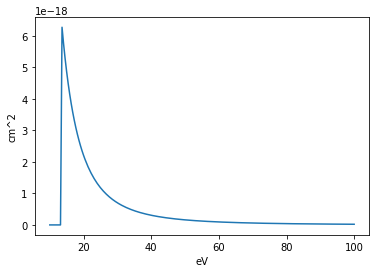

In [7]:
test_eV_array=np.linspace(10.,100,200)
test_AA_array=eV2lambdaAA(test_eV_array)
plt.plot(test_eV_array,sigma_HI_nu(test_eV_array))
plt.xlabel("eV")
plt.ylabel("cm^2")

$$ d \tau = n \sigma dr $$

In [8]:
eV2lambdaAA(13.6)

911.6485294117647

In [9]:
clight

<<class 'astropy.constants.codata2014.CODATA2014'> name='Speed of light in vacuum' value=299792458.0 uncertainty=0.0 unit='m / s' reference='CODATA 2014'>

In [10]:
def calc_tau(nHI,dr_pMpc,eVarray):
    dr=dr_pMpc*3.08e24 #cm
    return nHI*dr*sigma_HI_nu(eVarray) #

In [11]:
def tau_profile(vspec_out,nHI,dr_pMpc):
    lambdaAA_out=eV2lambdaAA(13.6)*(1-vspec_out/2.9979246e5)
    eV_out=lambdaAA2eV(lambdaAA_out)
    return calc_tau(nHI,dr_pMpc,eV_out)

In [12]:
def tau_per_denpixel(vspec_out,pos_pMpc,nHI,vlos,dr_pMpc,Hz):
    vel_space_pos=pos_pMpc*Hz-vlos
    v_relative=vspec_out-vel_space_pos
    lambdaAA_out=eV2lambdaAA(13.6)*(1-v_relative/2.9979246e5)
    eV_out=lambdaAA2eV(lambdaAA_out)
    return calc_tau(nHI,dr_pMpc,eV_out)

In [13]:
# observers usually use range 820~912 AA
(912-820)/912*clight.to("km/s")

<Quantity 30242.22164035 km / s>

In [78]:
Hz

673.860190064121

### a fake uniform sightline as a test

In [14]:
dr_pMpc=0.01
Ncell=500
print("total integration length= {:f} pMpc".format(dr_pMpc*Ncell))
dr_pMpc_array=np.ones(Ncell)*dr_pMpc
pos_arr_pMpc=np.cumsum(dr_pMpc_array)
nHI_arr=np.ones(Ncell)*1e-8
vlos_arr=np.zeros(Ncell)

total integration length= 5.000000 pMpc


In [15]:
def integ_tau(vspec_out,pos_arr_pMpc,nHI,vlos,dr_pMpc,Hz):
    tau_matrix=np.array([tau_per_denpixel(vspec_out,pos_arr_pMpc[i],\
                       nHI[i],vlos[i],dr_pMpc[i],Hz) for i in range(len(pos_arr_pMpc))])
    return np.sum(tau_matrix,axis=0)

In [16]:
vout=np.linspace(0,30000,100)
AAout=eV2lambdaAA(13.6)*(1-vout/2.9979246e5)

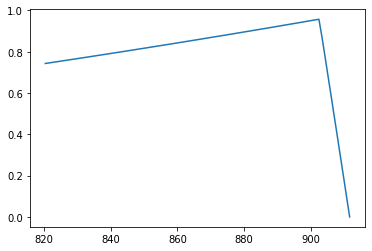

In [17]:
plt.plot(AAout,integ_tau(vout,pos_arr_pMpc,nHI_arr,vlos_arr,dr_pMpc_array,600))


Text(0, 0.5, 'transmitted flux')

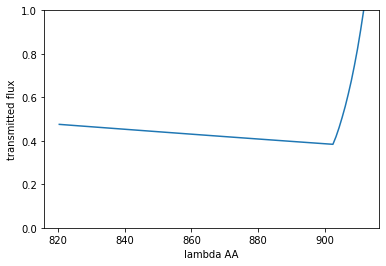

In [18]:
plt.plot(AAout,np.exp(-integ_tau(vout,pos_arr_pMpc,nHI_arr,vlos_arr,dr_pMpc_array,600)))
plt.ylim(0,1)
plt.xlabel("lambda AA")
plt.ylabel("transmitted flux")

In [79]:
rootpath="/data/hqchen/mfp_project/data/"
folder="F_a0.1452_50pMpc/"
zuni=1/0.1452-1
Hz=cosmo.H(zuni).value
print(zuni)

5.887052341597796


In [21]:
tau_profiles=[]
losList=glob.glob(rootpath+folder+"lightray*h5")
for losName in losList[:]:
    los=yt.load(losName)
    dr=los.r["dl"].to("Mpc").value
    dist=np.cumsum(los.r["dl"].to("Mpc").value)
    nHI=(los.r['gas','RT_HVAR_HI']/yt.units.mp).in_units("cm**-3").v
    vlos=los.r['gas','velocity_los'].to("km/s").v
    cut_inner=0.15
    tau_profiles.append(integ_tau(vout,dist[dist>cut_inner],nHI[dist>cut_inner],vlos[dist>cut_inner],dr[dist>cut_inner],Hz))

yt : [INFO     ] 2024-02-01 13:04:09,680 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:09,680 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:09,681 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:09,682 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:04:09,683 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:09,684 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:09,688 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:09,689 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:09,690 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:09,691 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:04:14,084 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:14,085 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:04:14,086 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:14,086 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:14,087 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:14,088 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:14,088 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:14,089 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:04:14,095 Allocating for 6.983e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:04:14,101 Identified 4.545e+03 octs
yt : [INFO     ] 2024-02-01 13:04:1

yt : [INFO     ] 2024-02-01 13:04:17,886 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:17,887 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:17,888 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:17,888 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:17,889 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:17,890 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:04:17,895 Allocating for 6.595e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:04:17,901 Identified 4.393e+03 octs
yt : [INFO     ] 2024-02-01 13:04:18,416 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:18,417 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:18,418 Parameters: domain

yt : [INFO     ] 2024-02-01 13:04:21,830 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:21,831 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:21,832 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:21,833 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:04:21,838 Allocating for 5.663e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:04:21,844 Identified 3.937e+03 octs
yt : [INFO     ] 2024-02-01 13:04:22,329 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:22,330 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:22,331 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:22,332 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:04:25,677 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:25,678 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:04:25,683 Allocating for 6.972e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:04:25,690 Identified 4.793e+03 octs
yt : [INFO     ] 2024-02-01 13:04:26,218 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:26,219 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:26,220 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:26,221 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:04:26,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:26,222 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:26,223 Para

yt : [INFO     ] 2024-02-01 13:04:29,689 Allocating for 6.897e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:04:29,695 Identified 4.569e+03 octs
yt : [INFO     ] 2024-02-01 13:04:30,259 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:30,260 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:30,261 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:30,262 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:04:30,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:30,264 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:30,264 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:30,265 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:30,266

yt : [INFO     ] 2024-02-01 13:04:33,930 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:33,931 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:33,932 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:33,933 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:04:33,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:33,934 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:33,935 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:33,936 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:33,936 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:33,937 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:04:37,574 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:37,575 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:04:37,576 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:37,577 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:37,578 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:37,578 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:37,579 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:37,580 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:04:37,585 Allocating for 7.696e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:04:37,591 Identified 5.425e+03 octs
yt : [INFO     ] 2024-02-01 13:04:3

yt : [INFO     ] 2024-02-01 13:04:41,294 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:41,294 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:41,295 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:41,296 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:41,296 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:41,297 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:04:41,303 Allocating for 5.264e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:04:41,308 Identified 3.561e+03 octs
yt : [INFO     ] 2024-02-01 13:04:41,747 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:41,748 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:41,749 Parameters: domain

yt : [INFO     ] 2024-02-01 13:04:44,817 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:44,818 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:44,818 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:44,819 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:04:44,824 Allocating for 6.395e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:04:44,831 Identified 4.305e+03 octs
yt : [INFO     ] 2024-02-01 13:04:45,373 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:45,374 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:45,375 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:45,376 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:04:48,456 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:48,456 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:04:48,462 Allocating for 7.402e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:04:48,468 Identified 5.017e+03 octs
yt : [INFO     ] 2024-02-01 13:04:48,978 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:48,979 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:48,980 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:48,981 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:04:48,982 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:48,982 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:48,983 Para

yt : [INFO     ] 2024-02-01 13:04:52,181 Allocating for 8.078e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:04:52,186 Identified 5.489e+03 octs
yt : [INFO     ] 2024-02-01 13:04:52,711 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:52,712 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:52,713 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:52,714 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:04:52,714 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:52,715 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:52,716 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:52,717 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:52,717

yt : [INFO     ] 2024-02-01 13:04:56,437 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:04:56,438 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:04:56,439 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:04:56,440 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:04:56,440 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:04:56,441 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:04:56,442 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:04:56,443 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:04:56,443 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:04:56,444 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:05:00,396 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:00,398 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:05:00,399 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:00,399 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:00,400 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:00,401 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:00,401 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:00,402 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:00,408 Allocating for 6.653e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:00,414 Identified 4.265e+03 octs
yt : [INFO     ] 2024-02-01 13:05:0

yt : [INFO     ] 2024-02-01 13:05:04,161 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:04,162 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:04,162 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:04,163 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:04,164 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:04,164 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:04,170 Allocating for 6.933e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:04,175 Identified 4.665e+03 octs
yt : [INFO     ] 2024-02-01 13:05:04,655 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:04,656 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:04,656 Parameters: domain

yt : [INFO     ] 2024-02-01 13:05:07,912 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:07,912 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:07,913 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:07,914 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:07,919 Allocating for 6.697e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:08,003 Identified 4.521e+03 octs
yt : [INFO     ] 2024-02-01 13:05:08,486 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:08,487 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:08,488 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:08,489 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:05:11,527 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:11,527 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:11,533 Allocating for 6.276e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:11,538 Identified 4.297e+03 octs
yt : [INFO     ] 2024-02-01 13:05:12,005 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:12,006 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:12,007 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:12,008 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:05:12,009 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:12,010 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:12,010 Para

yt : [INFO     ] 2024-02-01 13:05:15,491 Allocating for 5.452e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:15,496 Identified 3.761e+03 octs
yt : [INFO     ] 2024-02-01 13:05:15,944 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:15,945 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:15,946 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:15,947 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:05:15,947 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:15,948 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:15,949 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:15,950 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:15,950

yt : [INFO     ] 2024-02-01 13:05:19,727 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:19,728 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:19,729 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:19,730 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:05:19,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:19,732 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:19,732 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:19,733 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:19,734 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:19,734 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:05:23,546 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:23,547 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:05:23,548 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:23,549 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:23,549 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:23,550 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:23,551 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:23,551 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:23,557 Allocating for 6.923e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:23,562 Identified 4.489e+03 octs
yt : [INFO     ] 2024-02-01 13:05:2

yt : [INFO     ] 2024-02-01 13:05:27,188 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:27,189 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:27,190 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:27,190 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:27,191 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:27,192 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:27,197 Allocating for 7.110e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:27,203 Identified 4.889e+03 octs
yt : [INFO     ] 2024-02-01 13:05:27,698 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:27,699 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:27,700 Parameters: domain

yt : [INFO     ] 2024-02-01 13:05:30,839 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:30,840 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:30,841 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:30,841 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:30,847 Allocating for 7.673e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:30,852 Identified 5.201e+03 octs
yt : [INFO     ] 2024-02-01 13:05:31,350 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:31,351 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:31,352 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:31,353 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:05:34,506 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:34,506 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:34,512 Allocating for 6.835e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:34,517 Identified 4.433e+03 octs
yt : [INFO     ] 2024-02-01 13:05:35,015 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:35,016 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:35,017 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:35,018 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:05:35,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:35,020 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:35,020 Para

yt : [INFO     ] 2024-02-01 13:05:38,145 Allocating for 7.901e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:38,151 Identified 5.257e+03 octs
yt : [INFO     ] 2024-02-01 13:05:38,742 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:38,743 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:38,744 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:38,744 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:05:38,745 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:38,746 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:38,747 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:38,747 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:38,748

yt : [INFO     ] 2024-02-01 13:05:42,567 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:42,568 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:42,568 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:42,569 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:05:42,570 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:42,571 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:42,571 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:42,572 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:42,573 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:42,573 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:05:46,272 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:46,273 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:05:46,274 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:46,275 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:46,275 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:46,276 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:46,277 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:46,277 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:46,283 Allocating for 5.548e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:46,289 Identified 3.761e+03 octs
yt : [INFO     ] 2024-02-01 13:05:4

yt : [INFO     ] 2024-02-01 13:05:49,874 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:49,875 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:49,876 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:49,876 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:49,877 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:49,878 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:49,883 Allocating for 6.697e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:49,888 Identified 4.593e+03 octs
yt : [INFO     ] 2024-02-01 13:05:50,370 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:50,371 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:50,372 Parameters: domain

yt : [INFO     ] 2024-02-01 13:05:53,606 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:05:53,607 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:05:53,608 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:53,608 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:53,614 Allocating for 7.678e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:53,620 Identified 5.113e+03 octs
yt : [INFO     ] 2024-02-01 13:05:54,128 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:54,128 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:54,129 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:54,130 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:05:57,255 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:05:57,256 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:05:57,261 Allocating for 6.345e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:05:57,267 Identified 4.249e+03 octs
yt : [INFO     ] 2024-02-01 13:05:57,728 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:05:57,729 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:05:57,730 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:05:57,731 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:05:57,732 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:05:57,732 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:05:57,733 Para

yt : [INFO     ] 2024-02-01 13:06:00,848 Allocating for 7.345e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:00,855 Identified 5.033e+03 octs
yt : [INFO     ] 2024-02-01 13:06:01,360 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:01,361 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:01,362 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:01,363 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:01,363 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:01,364 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:01,365 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:01,365 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:01,366

yt : [INFO     ] 2024-02-01 13:06:05,084 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:05,085 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:05,086 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:05,087 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:05,088 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:05,088 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:05,089 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:05,090 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:05,090 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:05,091 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:06:08,834 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:08,835 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:08,836 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:08,836 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:08,837 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:08,838 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:08,838 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:08,839 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:06:08,844 Allocating for 7.314e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:08,850 Identified 4.809e+03 octs
yt : [INFO     ] 2024-02-01 13:06:0

yt : [INFO     ] 2024-02-01 13:06:12,658 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:12,658 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:12,659 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:12,660 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:12,660 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:12,661 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:06:12,667 Allocating for 6.603e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:12,673 Identified 4.417e+03 octs
yt : [INFO     ] 2024-02-01 13:06:13,170 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:13,171 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:13,172 Parameters: domain

yt : [INFO     ] 2024-02-01 13:06:16,283 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:16,283 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:16,284 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:16,285 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:06:16,290 Allocating for 6.364e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:16,295 Identified 4.209e+03 octs
yt : [INFO     ] 2024-02-01 13:06:16,759 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:16,759 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:16,760 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:16,761 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:06:19,969 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:19,969 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:06:19,975 Allocating for 6.236e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:19,980 Identified 4.225e+03 octs
yt : [INFO     ] 2024-02-01 13:06:20,440 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:20,441 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:20,441 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:20,442 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:20,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:20,444 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:20,445 Para

yt : [INFO     ] 2024-02-01 13:06:23,584 Allocating for 6.638e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:23,590 Identified 4.393e+03 octs
yt : [INFO     ] 2024-02-01 13:06:24,069 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:24,070 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:24,070 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:24,071 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:24,072 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:24,073 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:24,074 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:24,074 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:24,075

yt : [INFO     ] 2024-02-01 13:06:28,071 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:28,072 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:28,073 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:28,074 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:28,074 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:28,075 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:28,076 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:28,076 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:28,077 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:28,078 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:06:31,677 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:31,678 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:31,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:31,679 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:31,680 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:31,681 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:31,681 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:31,682 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:06:31,687 Allocating for 7.202e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:31,693 Identified 4.881e+03 octs
yt : [INFO     ] 2024-02-01 13:06:3

yt : [INFO     ] 2024-02-01 13:06:35,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:35,356 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:35,357 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:35,358 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:35,358 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:35,359 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:06:35,364 Allocating for 5.470e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:35,370 Identified 3.857e+03 octs
yt : [INFO     ] 2024-02-01 13:06:35,905 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:35,906 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:35,907 Parameters: domain

yt : [INFO     ] 2024-02-01 13:06:39,296 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:39,297 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:39,298 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:39,298 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:06:39,304 Allocating for 7.282e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:39,309 Identified 4.961e+03 octs
yt : [INFO     ] 2024-02-01 13:06:39,806 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:39,807 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:39,808 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:39,809 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:06:42,937 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:42,938 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:06:42,943 Allocating for 6.670e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:42,949 Identified 4.505e+03 octs
yt : [INFO     ] 2024-02-01 13:06:43,417 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:43,417 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:43,418 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:43,419 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:43,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:43,421 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:43,421 Para

yt : [INFO     ] 2024-02-01 13:06:46,762 Allocating for 6.916e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:46,768 Identified 4.545e+03 octs
yt : [INFO     ] 2024-02-01 13:06:47,270 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:47,271 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:47,272 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:47,273 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:47,273 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:47,274 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:47,275 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:47,275 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:47,276

yt : [INFO     ] 2024-02-01 13:06:50,933 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:50,934 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:50,935 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:50,936 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:50,937 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:50,938 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:50,938 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:50,939 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:50,940 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:50,940 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:06:55,172 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:06:55,173 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:06:55,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:55,174 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:55,175 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:55,176 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:55,176 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:55,177 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:06:55,183 Allocating for 7.169e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:55,189 Identified 4.969e+03 octs
yt : [INFO     ] 2024-02-01 13:06:5

yt : [INFO     ] 2024-02-01 13:06:59,141 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:06:59,142 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:06:59,142 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:06:59,143 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:06:59,144 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:06:59,144 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:06:59,150 Allocating for 6.704e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:06:59,156 Identified 3.833e+03 octs
yt : [INFO     ] 2024-02-01 13:06:59,673 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:06:59,674 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:06:59,675 Parameters: domain

yt : [INFO     ] 2024-02-01 13:07:03,034 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:03,035 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:03,035 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:03,036 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:07:03,041 Allocating for 6.691e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:03,047 Identified 4.233e+03 octs
yt : [INFO     ] 2024-02-01 13:07:03,641 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:03,642 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:03,643 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:03,644 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:07:06,859 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:06,860 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:07:06,865 Allocating for 7.006e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:06,871 Identified 4.801e+03 octs
yt : [INFO     ] 2024-02-01 13:07:07,366 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:07,367 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:07,368 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:07,369 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:07:07,370 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:07,370 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:07,371 Para

yt : [INFO     ] 2024-02-01 13:07:10,536 Allocating for 7.232e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:10,542 Identified 4.761e+03 octs
yt : [INFO     ] 2024-02-01 13:07:11,036 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:11,037 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:11,038 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:11,039 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:07:11,040 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:11,040 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:11,041 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:11,042 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:11,042

yt : [INFO     ] 2024-02-01 13:07:14,811 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:14,811 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:14,812 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:14,813 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:07:14,814 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:14,815 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:14,815 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:14,816 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:14,817 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:14,817 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:07:18,536 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:18,537 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:07:18,537 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:18,538 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:18,539 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:18,539 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:18,540 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:18,541 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:07:18,546 Allocating for 6.032e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:18,551 Identified 4.273e+03 octs
yt : [INFO     ] 2024-02-01 13:07:1

yt : [INFO     ] 2024-02-01 13:07:22,329 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:22,330 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:22,331 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:22,331 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:22,332 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:22,333 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:07:22,338 Allocating for 7.625e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:22,344 Identified 5.105e+03 octs
yt : [INFO     ] 2024-02-01 13:07:22,849 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:22,850 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:22,850 Parameters: domain

yt : [INFO     ] 2024-02-01 13:07:26,011 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:26,012 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:26,012 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:26,013 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:07:26,018 Allocating for 6.772e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:26,024 Identified 4.497e+03 octs
yt : [INFO     ] 2024-02-01 13:07:26,504 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:26,505 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:26,506 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:26,507 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:07:29,589 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:29,589 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:07:29,595 Allocating for 6.719e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:29,600 Identified 4.201e+03 octs
yt : [INFO     ] 2024-02-01 13:07:30,092 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:30,092 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:30,093 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:30,094 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:07:30,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:30,096 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:30,096 Para

yt : [INFO     ] 2024-02-01 13:07:33,336 Allocating for 7.812e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:33,342 Identified 5.497e+03 octs
yt : [INFO     ] 2024-02-01 13:07:33,848 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:33,849 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:33,850 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:33,851 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:07:33,852 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:33,853 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:33,853 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:33,854 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:33,855

yt : [INFO     ] 2024-02-01 13:07:37,468 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:37,469 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:37,470 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:37,471 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:07:37,471 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:37,472 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:37,473 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:37,473 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:37,474 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:37,475 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:07:41,034 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:41,035 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:07:41,036 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:41,036 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:41,037 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:41,038 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:41,038 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:41,039 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:07:41,044 Allocating for 6.053e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:41,050 Identified 4.289e+03 octs
yt : [INFO     ] 2024-02-01 13:07:4

yt : [INFO     ] 2024-02-01 13:07:44,987 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:44,988 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:44,988 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:44,989 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:44,989 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:44,990 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:07:44,995 Allocating for 6.498e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:45,001 Identified 4.233e+03 octs
yt : [INFO     ] 2024-02-01 13:07:45,471 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:45,472 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:45,473 Parameters: domain

yt : [INFO     ] 2024-02-01 13:07:48,665 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:48,666 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:48,666 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:48,667 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:07:48,672 Allocating for 6.512e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:48,678 Identified 4.369e+03 octs
yt : [INFO     ] 2024-02-01 13:07:49,168 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:49,169 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:49,170 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:49,171 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:07:52,302 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:07:52,303 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:07:52,308 Allocating for 7.422e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:52,313 Identified 5.145e+03 octs
yt : [INFO     ] 2024-02-01 13:07:52,936 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:52,937 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:52,938 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:52,939 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:07:52,940 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:52,940 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:52,941 Para

yt : [INFO     ] 2024-02-01 13:07:56,426 Allocating for 7.928e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:07:56,432 Identified 5.161e+03 octs
yt : [INFO     ] 2024-02-01 13:07:56,940 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:07:56,941 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:07:56,942 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:07:56,943 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:07:56,944 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:07:56,945 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:07:56,945 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:07:56,946 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:07:56,947

yt : [INFO     ] 2024-02-01 13:08:00,640 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:00,641 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:00,642 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:00,643 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:08:00,644 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:00,644 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:00,645 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:00,646 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:00,646 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:00,647 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:08:04,478 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:04,479 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:08:04,480 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:04,481 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:04,482 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:04,483 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:04,483 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:04,484 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:04,489 Allocating for 7.331e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:04,495 Identified 4.953e+03 octs
yt : [INFO     ] 2024-02-01 13:08:0

yt : [INFO     ] 2024-02-01 13:08:08,159 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:08,160 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:08,161 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:08,161 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:08,162 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:08,163 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:08,168 Allocating for 7.152e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:08,174 Identified 4.993e+03 octs
yt : [INFO     ] 2024-02-01 13:08:08,683 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:08,684 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:08,685 Parameters: domain

yt : [INFO     ] 2024-02-01 13:08:11,800 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:11,801 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:11,801 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:11,802 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:11,807 Allocating for 6.423e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:11,813 Identified 4.337e+03 octs
yt : [INFO     ] 2024-02-01 13:08:12,283 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:12,284 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:12,284 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:12,285 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:08:15,393 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:15,394 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:15,400 Allocating for 7.726e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:15,405 Identified 5.345e+03 octs
yt : [INFO     ] 2024-02-01 13:08:16,027 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:16,028 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:16,029 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:16,030 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:08:16,031 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:16,032 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:16,032 Para

yt : [INFO     ] 2024-02-01 13:08:19,199 Allocating for 6.729e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:19,205 Identified 4.553e+03 octs
yt : [INFO     ] 2024-02-01 13:08:19,676 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:19,677 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:19,678 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:19,679 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:08:19,680 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:19,681 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:19,681 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:19,682 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:19,682

yt : [INFO     ] 2024-02-01 13:08:23,375 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:23,376 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:23,377 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:23,378 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:08:23,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:23,379 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:23,380 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:23,381 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:23,381 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:23,382 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:08:27,357 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:27,357 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:08:27,358 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:27,359 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:27,360 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:27,360 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:27,361 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:27,362 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:27,367 Allocating for 7.167e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:27,373 Identified 4.785e+03 octs
yt : [INFO     ] 2024-02-01 13:08:2

yt : [INFO     ] 2024-02-01 13:08:31,170 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:31,170 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:31,171 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:31,172 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:31,172 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:31,173 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:31,179 Allocating for 7.271e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:31,185 Identified 4.681e+03 octs
yt : [INFO     ] 2024-02-01 13:08:31,911 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:31,912 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:31,913 Parameters: domain

yt : [INFO     ] 2024-02-01 13:08:35,049 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:35,050 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:35,050 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:35,051 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:35,057 Allocating for 7.041e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:35,062 Identified 4.737e+03 octs
yt : [INFO     ] 2024-02-01 13:08:35,561 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:35,562 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:35,562 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:35,563 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:08:39,092 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:39,092 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:39,098 Allocating for 5.849e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:39,103 Identified 4.009e+03 octs
yt : [INFO     ] 2024-02-01 13:08:39,546 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:39,547 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:39,548 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:39,549 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:08:39,550 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:39,550 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:39,551 Para

yt : [INFO     ] 2024-02-01 13:08:42,742 Allocating for 7.038e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:42,747 Identified 4.593e+03 octs
yt : [INFO     ] 2024-02-01 13:08:43,254 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:43,255 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:43,255 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:43,256 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:08:43,257 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:43,258 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:43,258 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:43,259 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:43,260

yt : [INFO     ] 2024-02-01 13:08:46,953 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:46,954 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:46,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:46,956 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:08:46,957 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:46,957 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:46,958 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:46,959 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:46,959 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:46,960 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:08:50,737 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:50,738 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:08:50,738 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:50,739 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:50,740 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:50,740 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:50,741 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:50,742 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:50,747 Allocating for 5.374e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:50,752 Identified 3.801e+03 octs
yt : [INFO     ] 2024-02-01 13:08:5

yt : [INFO     ] 2024-02-01 13:08:54,323 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:08:54,323 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:08:54,324 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:54,325 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:54,325 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:54,326 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:54,331 Allocating for 7.230e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:54,337 Identified 5.089e+03 octs
yt : [INFO     ] 2024-02-01 13:08:54,839 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:54,840 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:54,841 Parameters: domain

yt : [INFO     ] 2024-02-01 13:08:57,945 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:08:57,945 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:08:57,946 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:08:57,947 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:08:57,952 Allocating for 7.005e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:08:57,958 Identified 4.593e+03 octs
yt : [INFO     ] 2024-02-01 13:08:58,445 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:08:58,446 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:08:58,447 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:08:58,448 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:09:01,692 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:01,693 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:09:01,698 Allocating for 6.419e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:01,703 Identified 4.393e+03 octs
yt : [INFO     ] 2024-02-01 13:09:02,301 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:02,302 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:02,303 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:02,304 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:02,305 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:02,306 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:02,306 Para

yt : [INFO     ] 2024-02-01 13:09:05,530 Allocating for 7.933e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:05,537 Identified 5.449e+03 octs
yt : [INFO     ] 2024-02-01 13:09:06,050 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:06,051 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:06,052 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:06,052 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:06,053 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:06,054 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:06,055 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:06,055 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:06,056

yt : [INFO     ] 2024-02-01 13:09:10,142 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:10,143 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:10,144 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:10,145 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:10,145 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:10,146 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:10,147 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:10,148 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:10,148 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:10,149 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:09:13,999 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:14,000 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:14,001 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:14,001 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:14,002 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:14,003 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:14,004 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:14,005 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:09:14,010 Allocating for 8.207e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:14,016 Identified 5.705e+03 octs
yt : [INFO     ] 2024-02-01 13:09:1

yt : [INFO     ] 2024-02-01 13:09:17,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:17,671 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:17,671 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:17,672 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:17,673 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:17,674 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:09:17,679 Allocating for 6.853e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:17,685 Identified 4.641e+03 octs
yt : [INFO     ] 2024-02-01 13:09:18,153 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:18,155 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:18,156 Parameters: domain

yt : [INFO     ] 2024-02-01 13:09:21,398 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:21,399 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:21,400 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:21,400 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:09:21,406 Allocating for 7.152e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:21,412 Identified 4.705e+03 octs
yt : [INFO     ] 2024-02-01 13:09:22,024 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:22,025 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:22,026 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:22,027 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:09:26,140 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:26,141 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:09:26,149 Allocating for 7.416e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:26,158 Identified 4.881e+03 octs
yt : [INFO     ] 2024-02-01 13:09:26,940 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:26,941 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:26,942 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:26,943 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:26,944 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:26,945 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:26,946 Para

yt : [INFO     ] 2024-02-01 13:09:30,443 Allocating for 7.711e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:30,449 Identified 5.113e+03 octs
yt : [INFO     ] 2024-02-01 13:09:31,001 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:31,002 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:31,002 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:31,003 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:31,004 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:31,005 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:31,005 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:31,006 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:31,007

yt : [INFO     ] 2024-02-01 13:09:34,985 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:34,986 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:34,987 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:34,988 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:34,989 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:34,990 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:34,990 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:34,991 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:34,991 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:34,992 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:09:39,021 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:39,022 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:39,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:39,023 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:39,024 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:39,025 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:39,025 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:39,026 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:09:39,032 Allocating for 5.867e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:39,037 Identified 3.969e+03 octs
yt : [INFO     ] 2024-02-01 13:09:3

yt : [INFO     ] 2024-02-01 13:09:42,653 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:42,653 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:42,654 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:42,655 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:42,655 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:42,656 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:09:42,662 Allocating for 7.255e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:42,668 Identified 4.857e+03 octs
yt : [INFO     ] 2024-02-01 13:09:43,278 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:43,279 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:43,280 Parameters: domain

yt : [INFO     ] 2024-02-01 13:09:46,820 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:46,820 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:46,821 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:46,822 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:09:46,827 Allocating for 6.432e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:46,833 Identified 4.385e+03 octs
yt : [INFO     ] 2024-02-01 13:09:47,313 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:47,314 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:47,315 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:47,316 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:09:50,498 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:50,498 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:09:50,504 Allocating for 6.062e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:50,510 Identified 4.185e+03 octs
yt : [INFO     ] 2024-02-01 13:09:50,979 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:50,980 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:50,981 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:50,982 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:50,982 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:50,983 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:50,984 Para

yt : [INFO     ] 2024-02-01 13:09:54,138 Allocating for 7.694e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:09:54,144 Identified 5.041e+03 octs
yt : [INFO     ] 2024-02-01 13:09:54,650 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:54,651 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:54,652 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:54,652 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:54,653 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:54,654 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:54,655 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:54,655 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:54,656

yt : [INFO     ] 2024-02-01 13:09:58,376 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:09:58,377 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:09:58,378 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:09:58,379 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:09:58,380 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:09:58,380 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:09:58,381 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:09:58,382 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:09:58,382 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:09:58,383 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:10:02,255 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:02,256 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:10:02,257 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:02,257 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:02,258 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:02,259 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:02,259 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:02,260 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:02,266 Allocating for 7.307e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:02,272 Identified 4.945e+03 octs
yt : [INFO     ] 2024-02-01 13:10:0

yt : [INFO     ] 2024-02-01 13:10:06,224 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:06,224 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:06,225 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:06,226 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:06,226 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:06,227 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:06,233 Allocating for 7.507e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:06,240 Identified 5.025e+03 octs
yt : [INFO     ] 2024-02-01 13:10:06,748 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:06,749 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:06,750 Parameters: domain

yt : [INFO     ] 2024-02-01 13:10:09,849 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:09,850 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:09,850 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:09,851 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:09,857 Allocating for 5.687e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:09,862 Identified 4.097e+03 octs
yt : [INFO     ] 2024-02-01 13:10:10,318 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:10,319 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:10,320 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:10,321 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:10:13,523 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:13,524 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:13,529 Allocating for 7.972e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:13,535 Identified 5.721e+03 octs
yt : [INFO     ] 2024-02-01 13:10:14,058 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:14,059 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:14,060 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:14,061 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:10:14,062 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:14,062 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:14,063 Para

yt : [INFO     ] 2024-02-01 13:10:17,221 Allocating for 6.745e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:17,227 Identified 4.625e+03 octs
yt : [INFO     ] 2024-02-01 13:10:17,711 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:17,712 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:17,713 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:17,714 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:10:17,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:17,716 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:17,716 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:17,717 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:17,718

yt : [INFO     ] 2024-02-01 13:10:21,307 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:21,308 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:21,309 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:21,309 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:10:21,310 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:21,311 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:21,312 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:21,312 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:21,313 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:21,314 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:10:24,900 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:24,901 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:10:24,902 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:24,903 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:24,903 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:24,904 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:24,905 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:24,905 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:24,911 Allocating for 7.702e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:24,916 Identified 5.113e+03 octs
yt : [INFO     ] 2024-02-01 13:10:2

yt : [INFO     ] 2024-02-01 13:10:28,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:28,701 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:28,701 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:28,702 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:28,703 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:28,704 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:28,709 Allocating for 7.495e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:28,715 Identified 5.145e+03 octs
yt : [INFO     ] 2024-02-01 13:10:29,361 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:29,362 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:29,363 Parameters: domain

yt : [INFO     ] 2024-02-01 13:10:32,519 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:32,519 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:32,520 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:32,521 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:32,526 Allocating for 6.211e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:32,532 Identified 4.177e+03 octs
yt : [INFO     ] 2024-02-01 13:10:33,006 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:33,007 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:33,008 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:33,009 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:10:36,166 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:36,166 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:36,172 Allocating for 7.852e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:36,178 Identified 5.433e+03 octs
yt : [INFO     ] 2024-02-01 13:10:36,700 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:36,701 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:36,702 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:36,702 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:10:36,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:36,704 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:36,705 Para

yt : [INFO     ] 2024-02-01 13:10:40,078 Allocating for 5.221e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:40,084 Identified 3.585e+03 octs
yt : [INFO     ] 2024-02-01 13:10:40,522 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:40,523 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:40,524 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:40,524 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:10:40,525 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:40,526 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:40,527 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:40,527 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:40,528

yt : [INFO     ] 2024-02-01 13:10:44,265 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:44,266 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:44,267 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:44,268 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:10:44,269 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:44,269 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:44,270 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:44,271 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:44,271 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:44,272 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:10:48,128 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:48,129 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:10:48,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:48,130 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:48,131 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:48,131 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:48,132 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:48,133 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:48,138 Allocating for 7.860e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:48,144 Identified 5.409e+03 octs
yt : [INFO     ] 2024-02-01 13:10:4

yt : [INFO     ] 2024-02-01 13:10:51,906 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:10:51,907 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:10:51,907 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:51,908 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:51,909 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:51,909 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:51,915 Allocating for 5.591e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:51,920 Identified 3.881e+03 octs
yt : [INFO     ] 2024-02-01 13:10:52,378 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:52,379 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:52,380 Parameters: domain

yt : [INFO     ] 2024-02-01 13:10:55,786 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:10:55,787 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:10:55,788 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:10:55,788 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:10:55,794 Allocating for 7.598e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:10:55,800 Identified 5.305e+03 octs
yt : [INFO     ] 2024-02-01 13:10:56,327 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:10:56,328 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:10:56,329 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:10:56,330 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:11:00,028 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:00,029 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:11:00,034 Allocating for 6.971e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:00,041 Identified 4.577e+03 octs
yt : [INFO     ] 2024-02-01 13:11:00,529 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:00,530 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:00,531 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:00,532 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:00,533 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:00,533 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:00,534 Para

yt : [INFO     ] 2024-02-01 13:11:03,968 Allocating for 5.556e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:03,974 Identified 3.905e+03 octs
yt : [INFO     ] 2024-02-01 13:11:04,412 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:04,413 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:04,413 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:04,414 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:04,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:04,416 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:04,417 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:04,418 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:04,418

yt : [INFO     ] 2024-02-01 13:11:08,170 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:08,171 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:08,172 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:08,173 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:08,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:08,174 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:08,175 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:08,176 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:08,176 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:08,177 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:11:11,954 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:11,954 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:11,955 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:11,956 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:11,957 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:11,957 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:11,958 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:11,959 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:11:11,965 Allocating for 6.769e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:11,970 Identified 4.649e+03 octs
yt : [INFO     ] 2024-02-01 13:11:1

yt : [INFO     ] 2024-02-01 13:11:15,895 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:15,895 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:15,896 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:15,897 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:15,897 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:15,898 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:11:15,904 Allocating for 7.246e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:15,910 Identified 4.801e+03 octs
yt : [INFO     ] 2024-02-01 13:11:16,412 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:16,413 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:16,414 Parameters: domain

yt : [INFO     ] 2024-02-01 13:11:19,852 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:19,853 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:19,854 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:19,854 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:11:19,860 Allocating for 6.605e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:19,866 Identified 4.601e+03 octs
yt : [INFO     ] 2024-02-01 13:11:20,348 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:20,348 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:20,349 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:20,351 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:11:23,479 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:23,479 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:11:23,485 Allocating for 6.054e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:23,491 Identified 4.209e+03 octs
yt : [INFO     ] 2024-02-01 13:11:23,953 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:23,954 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:23,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:23,955 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:23,956 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:23,957 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:23,958 Para

yt : [INFO     ] 2024-02-01 13:11:27,143 Allocating for 6.428e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:27,149 Identified 4.105e+03 octs
yt : [INFO     ] 2024-02-01 13:11:27,636 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:27,637 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:27,638 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:27,639 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:27,640 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:27,640 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:27,641 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:27,642 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:27,642

yt : [INFO     ] 2024-02-01 13:11:31,467 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:31,468 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:31,469 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:31,470 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:31,471 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:31,472 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:31,472 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:31,473 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:31,474 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:31,474 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:11:35,077 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:35,078 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:35,078 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:35,079 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:35,080 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:35,080 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:35,081 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:35,082 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:11:35,087 Allocating for 7.718e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:35,093 Identified 5.385e+03 octs
yt : [INFO     ] 2024-02-01 13:11:3

yt : [INFO     ] 2024-02-01 13:11:38,824 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:38,824 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:38,825 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:38,826 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:38,826 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:38,827 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:11:38,833 Allocating for 6.856e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:38,839 Identified 4.601e+03 octs
yt : [INFO     ] 2024-02-01 13:11:39,336 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:39,337 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:39,338 Parameters: domain

yt : [INFO     ] 2024-02-01 13:11:42,664 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:42,664 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:42,665 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:42,666 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:11:42,671 Allocating for 5.596e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:42,677 Identified 3.977e+03 octs
yt : [INFO     ] 2024-02-01 13:11:43,128 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:43,129 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:43,130 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:43,131 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:11:46,314 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:46,315 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:11:46,320 Allocating for 7.387e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:46,326 Identified 4.793e+03 octs
yt : [INFO     ] 2024-02-01 13:11:46,825 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:46,826 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:46,827 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:46,828 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:46,829 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:46,830 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:46,830 Para

yt : [INFO     ] 2024-02-01 13:11:50,050 Allocating for 7.587e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:50,057 Identified 5.145e+03 octs
yt : [INFO     ] 2024-02-01 13:11:50,562 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:50,563 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:50,564 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:50,565 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:50,566 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:50,566 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:50,567 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:50,568 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:50,568

yt : [INFO     ] 2024-02-01 13:11:54,286 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:11:54,287 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:11:54,287 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:54,288 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:54,289 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:54,290 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:54,291 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:54,291 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:54,292 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:54,293 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:11:58,038 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:11:58,039 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:11:58,040 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:11:58,041 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:11:58,041 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:11:58,042 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:11:58,043 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:11:58,043 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:11:58,049 Allocating for 6.483e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:11:58,054 Identified 4.425e+03 octs
yt : [INFO     ] 2024-02-01 13:11:5

yt : [INFO     ] 2024-02-01 13:12:01,738 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:01,739 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:01,739 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:01,740 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:01,740 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:01,741 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:01,747 Allocating for 6.282e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:01,752 Identified 4.041e+03 octs
yt : [INFO     ] 2024-02-01 13:12:02,222 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:02,223 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:02,223 Parameters: domain

yt : [INFO     ] 2024-02-01 13:12:05,409 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:05,410 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:05,411 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:05,411 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:05,417 Allocating for 7.042e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:05,422 Identified 4.665e+03 octs
yt : [INFO     ] 2024-02-01 13:12:05,913 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:05,914 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:05,914 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:05,915 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:12:09,127 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:09,127 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:09,133 Allocating for 5.563e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:09,138 Identified 3.889e+03 octs
yt : [INFO     ] 2024-02-01 13:12:09,602 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:09,602 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:09,603 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:09,604 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:12:09,605 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:09,606 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:09,606 Para

yt : [INFO     ] 2024-02-01 13:12:12,816 Allocating for 6.834e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:12,822 Identified 3.841e+03 octs
yt : [INFO     ] 2024-02-01 13:12:13,307 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:13,308 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:13,308 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:13,309 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:12:13,310 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:13,311 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:13,312 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:13,312 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:13,313

yt : [INFO     ] 2024-02-01 13:12:16,947 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:16,948 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:16,949 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:16,950 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:12:16,951 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:16,951 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:16,952 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:16,953 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:16,953 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:16,954 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:12:20,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:20,956 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:12:20,957 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:20,957 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:20,958 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:20,959 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:20,959 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:20,960 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:20,965 Allocating for 5.248e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:20,970 Identified 3.521e+03 octs
yt : [INFO     ] 2024-02-01 13:12:2

yt : [INFO     ] 2024-02-01 13:12:24,597 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:24,597 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:24,598 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:24,599 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:24,599 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:24,600 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:24,606 Allocating for 7.855e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:24,611 Identified 5.385e+03 octs
yt : [INFO     ] 2024-02-01 13:12:25,124 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:25,125 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:25,126 Parameters: domain

yt : [INFO     ] 2024-02-01 13:12:28,326 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:28,326 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:28,327 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:28,328 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:28,333 Allocating for 8.066e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:28,339 Identified 5.201e+03 octs
yt : [INFO     ] 2024-02-01 13:12:28,856 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:28,857 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:28,858 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:28,859 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:12:32,156 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:32,157 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:32,162 Allocating for 6.785e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:32,168 Identified 4.633e+03 octs
yt : [INFO     ] 2024-02-01 13:12:32,662 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:32,663 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:32,664 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:32,665 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:12:32,666 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:32,667 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:32,667 Para

yt : [INFO     ] 2024-02-01 13:12:35,797 Allocating for 8.253e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:35,803 Identified 5.601e+03 octs
yt : [INFO     ] 2024-02-01 13:12:36,356 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:36,357 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:36,358 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:36,359 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:12:36,360 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:36,361 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:36,361 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:36,362 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:36,363

yt : [INFO     ] 2024-02-01 13:12:40,215 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:40,216 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:40,217 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:40,218 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:12:40,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:40,220 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:40,220 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:40,221 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:40,222 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:40,222 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:12:44,116 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:44,117 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:12:44,118 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:44,119 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:44,120 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:44,120 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:44,121 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:44,122 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:44,127 Allocating for 6.581e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:44,132 Identified 4.425e+03 octs
yt : [INFO     ] 2024-02-01 13:12:4

yt : [INFO     ] 2024-02-01 13:12:48,070 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:48,071 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:48,071 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:48,072 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:48,073 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:48,074 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:48,081 Allocating for 6.083e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:48,089 Identified 4.025e+03 octs
yt : [INFO     ] 2024-02-01 13:12:48,582 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:48,583 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:48,584 Parameters: domain

yt : [INFO     ] 2024-02-01 13:12:52,180 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:12:52,181 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:12:52,181 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:52,182 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:52,187 Allocating for 8.040e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:52,194 Identified 5.289e+03 octs
yt : [INFO     ] 2024-02-01 13:12:52,736 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:52,736 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:52,737 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:52,738 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13

yt : [ERROR    ] 2024-02-01 13:12:56,004 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:12:56,005 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:12:56,011 Allocating for 6.829e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:56,016 Identified 4.521e+03 octs
yt : [INFO     ] 2024-02-01 13:12:56,494 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:12:56,495 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:12:56,496 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:12:56,497 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:12:56,498 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:12:56,498 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:12:56,499 Para

yt : [INFO     ] 2024-02-01 13:12:59,873 Allocating for 7.923e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:12:59,879 Identified 5.289e+03 octs
yt : [INFO     ] 2024-02-01 13:13:00,385 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:13:00,386 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:13:00,386 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:13:00,387 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:13:00,388 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:13:00,389 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:13:00,390 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:13:00,390 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:13:00,391

yt : [INFO     ] 2024-02-01 13:13:04,207 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-01 13:13:04,208 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-01 13:13:04,209 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:13:04,210 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:13:04,211 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:13:04,211 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:13:04,212 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:13:04,213 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:13:04,213 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:13:04,214 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-01 13:13:08,016 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-01 13:13:08,017 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-01 13:13:08,018 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-01 13:13:08,019 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-01 13:13:08,020 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-01 13:13:08,020 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-01 13:13:08,021 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-01 13:13:08,022 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-01 13:13:08,027 Allocating for 6.114e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-01 13:13:08,033 Identified 4.113e+03 octs
yt : [INFO     ] 2024-02-01 13:13:0

In [172]:
# np.save("tau_profiles_F_a0.1287.npy",tau_profiles)

In [27]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [63]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=20

906.1195618695234

In [99]:
mfp=clight_kmps*(911.6485294117647-AAout[np.argmin(np.abs(np.median(flux_mat,axis=0)-1/np.e))])/911.6485294117647/Hz

In [100]:
print(mfp)

2.6981588063233257


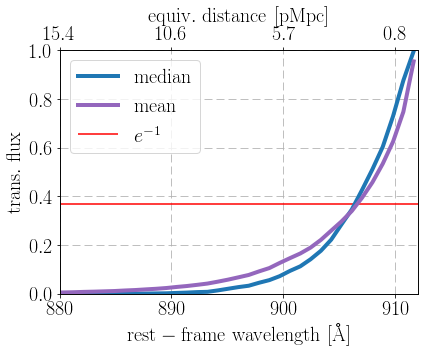

In [101]:
fig=plt.figure(figsize=(6,5))
ax=fig.subplots()
AA_tau1_list_Fz58=[]

flux_mat=np.exp(-np.array(tau_profiles))
plt.plot(AAout,np.median(flux_mat,axis=0),c="tab:blue",label=r"$\rm median$",lw=4)

plt.plot(AAout,np.mean(flux_mat,axis=0),c="tab:purple",label=r"$\rm mean$",lw=4)

plt.hlines(np.exp(-1),820,912,color='r',label=r"$e^{-1}$")

# for tp in tau_profiles:
#     plt.plot(AAout,np.exp(-tp),c="tab:blue",alpha=0.01)
#     AA_tau1=AAout[np.where(tp>1)[0][0]]
#     AA_tau1_list_Fz58.append(AA_tau1)
plt.ylim(0,1)
plt.xlim(880,912)
plt.grid(dashes=(10,5))
plt.legend()
plt.xlabel(r"$\rm rest-frame \  wavelength \ [\r{A}]$")
plt.ylabel(r"$\rm trans. \ flux$")

ax2 = ax.twiny()
new_tick_locations = np.linspace(880,910,4)  # Adjust these as needed
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
labels=clight_kmps*(911.6485294117647-new_tick_locations)/911.6485294117647/Hz
labels=[r"${:.1f}$".format(d) for d in labels]
ax2.set_xticklabels(labels)  # Adjust labels as needed
ax2.set_xlabel(r"$\rm equiv. \ distance \ [pMpc]$")
plt.tight_layout()
plt.savefig("no_qso_spec.pdf")

In [45]:
tau_profiles

[array([0.00000000e+00, 9.13215969e-01, 1.59248447e+00, 1.62935815e+00,
        1.66205737e+00, 1.68434631e+00, 1.73734616e+00, 1.81884747e+00,
        1.88816968e+00, 1.90221822e+00, 1.90182386e+00, 1.94659654e+00,
        1.94902972e+00, 1.96324043e+00, 2.17174389e+00, 2.24234176e+00,
        2.70102830e+00, 2.94892948e+00, 2.95330380e+00, 3.01560188e+00,
        3.63123590e+00, 3.66403789e+00, 3.70570605e+00, 3.81512438e+00,
        3.91303145e+00, 3.92320087e+00, 4.00353404e+00, 4.07154207e+00,
        4.09763766e+00, 4.36121347e+00, 4.54861182e+00, 4.64671882e+00,
        4.67565673e+00, 4.68561850e+00, 4.72545495e+00, 4.89429434e+00,
        5.01378584e+00, 5.08423860e+00, 5.13627500e+00, 5.14783883e+00,
        5.48870830e+00, 5.51600079e+00, 5.54460932e+00, 5.56576839e+00,
        5.56472646e+00, 5.59135820e+00, 5.64647433e+00, 5.70651475e+00,
        5.74558008e+00, 5.82931401e+00, 6.06898364e+00, 6.14002037e+00,
        6.22250638e+00, 6.26163393e+00, 6.42010237e+00, 9.088060

In [48]:
np.e**-1

0.36787944117144233

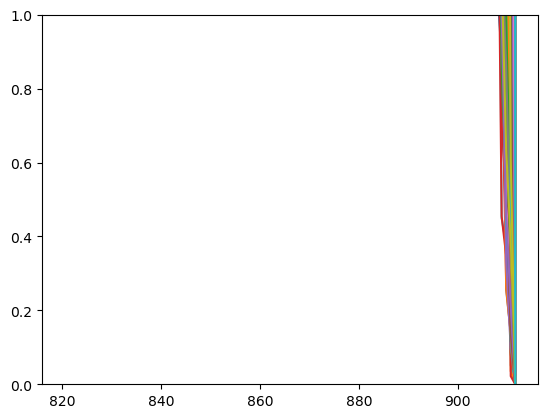

In [178]:
AA_tau1_list=[]
for tp in tau_profiles:
    plt.plot(AAout,tp)
    AA_tau1=AAout[np.where(tp>1)[0][0]]
    AA_tau1_list.append(AA_tau1)
    plt.ylim(0,1)
    plt.grid()

In [174]:
mfp_pMpc_Fz68

array([0.37564251, 0.75128502, 0.37564251, 0.75128502, 0.37564251,
       0.37564251, 0.37564251, 0.37564251, 0.75128502, 1.12692754,
       0.37564251, 1.12692754, 0.75128502, 0.37564251, 0.37564251,
       0.37564251, 0.75128502, 0.75128502, 0.37564251, 0.37564251,
       0.37564251, 0.75128502, 0.37564251, 0.75128502, 0.75128502,
       0.75128502, 0.37564251, 0.75128502, 0.37564251, 0.37564251,
       0.75128502, 0.75128502, 0.37564251, 0.37564251, 0.37564251,
       0.37564251, 0.37564251, 0.75128502, 0.37564251, 0.75128502,
       0.37564251, 0.37564251, 0.37564251, 0.        , 0.37564251,
       0.37564251, 0.37564251, 0.37564251, 0.37564251, 0.75128502,
       1.12692754, 0.37564251, 1.12692754, 0.75128502, 0.37564251,
       0.37564251, 0.75128502, 0.37564251, 0.        , 1.12692754,
       1.12692754, 0.37564251, 0.37564251, 0.75128502, 0.75128502,
       1.12692754, 1.12692754, 1.12692754, 0.37564251, 0.37564251,
       0.75128502, 0.37564251, 1.12692754, 0.        , 0.37564

8.92864687051665 8.639777778698454
6.974178879970217 6.761565218111827
1.9364371499647977 1.8782125605866264
1.2869512465139454 1.126927536351948
0.6149267923360472 0.37564251211731603


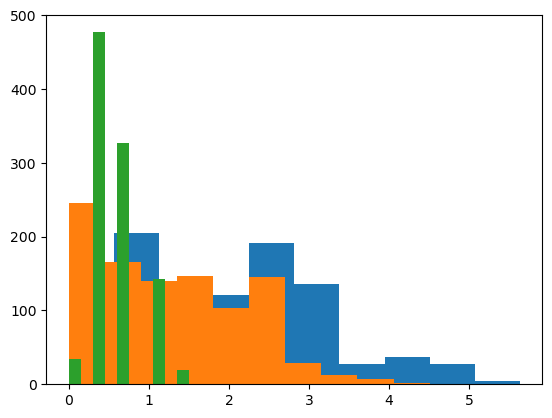

In [175]:
mfp_pMpc_z525=(eV2lambdaAA(13.6)-np.array(AA_tau1_list))/eV2lambdaAA(13.6)*clight_kmps/Hz

mfp_pMpc_Fz52=(eV2lambdaAA(13.6)-np.array(AA_tau1_list_Fz52))/eV2lambdaAA(13.6)*clight_kmps/Hz

mfp_pMpc_Fz61=(eV2lambdaAA(13.6)-np.array(AA_tau1_list_Fz61))/eV2lambdaAA(13.6)*clight_kmps/Hz
mfp_pMpc_Fz64=(eV2lambdaAA(13.6)-np.array(AA_tau1_list_Fz64))/eV2lambdaAA(13.6)*clight_kmps/Hz
mfp_pMpc_Fz68=(eV2lambdaAA(13.6)-np.array(AA_tau1_list_Fz68))/eV2lambdaAA(13.6)*clight_kmps/Hz


# plt.hist(mfp_pMpc_z525)
# plt.hist(mfp_pMpc_Fz52)
plt.hist(mfp_pMpc_Fz61)
plt.hist(mfp_pMpc_Fz64)
plt.hist(mfp_pMpc_Fz68,bins=10)
print(np.mean(mfp_pMpc_z525),np.median(mfp_pMpc_z525))
print(np.mean(mfp_pMpc_Fz52),np.median(mfp_pMpc_Fz52))
print(np.mean(mfp_pMpc_Fz61),np.median(mfp_pMpc_Fz61))
print(np.mean(mfp_pMpc_Fz64),np.median(mfp_pMpc_Fz64))
print(np.mean(mfp_pMpc_Fz68),np.median(mfp_pMpc_Fz68))

(array([ 34.,   0., 477.,   0., 327.,   0.,   0., 142.,   0.,  20.]),
 array([0.        , 0.150257  , 0.30051401, 0.45077101, 0.60102802,
        0.75128502, 0.90154203, 1.05179903, 1.20205604, 1.35231304,
        1.50257005]),
 <BarContainer object of 10 artists>)

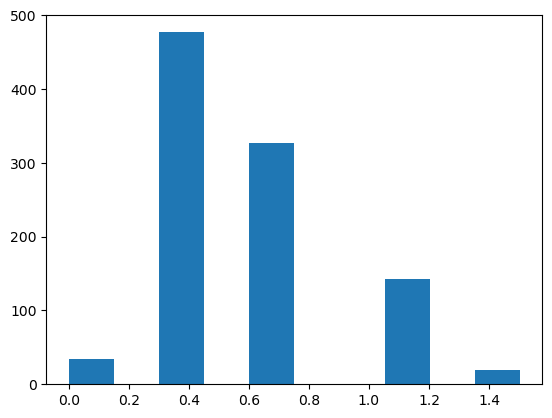

In [177]:
plt.hist(mfp_pMpc_Fz68,bins=10)

In [176]:
Hz

806.6986329653181

3.244720589908742 2.5799527616555147


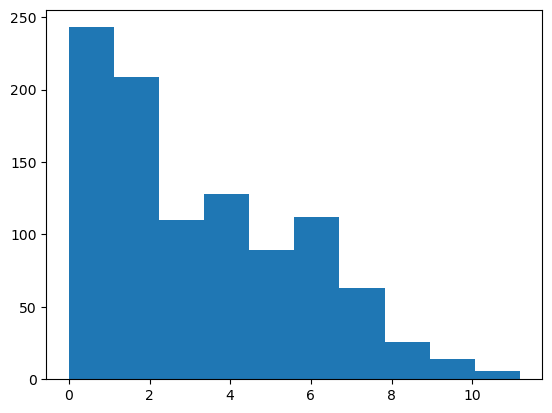

In [134]:
mfp_pMpc_z610=(eV2lambdaAA(13.6)-np.array(AA_tau1_list_z610))/eV2lambdaAA(13.6)*clight_kmps/Hz
plt.hist(mfp_pMpc_z610)
print(np.mean(mfp_pMpc_z610),np.median(mfp_pMpc_z610))

(array([243., 209., 110., 128.,  89., 112.,  63.,  26.,  14.,   6.]),
 array([ 0.        ,  1.11797953,  2.23595906,  3.35393859,  4.47191812,
         5.58989765,  6.70787718,  7.82585671,  8.94383624, 10.06181577,
        11.1797953 ]),
 <BarContainer object of 10 artists>)

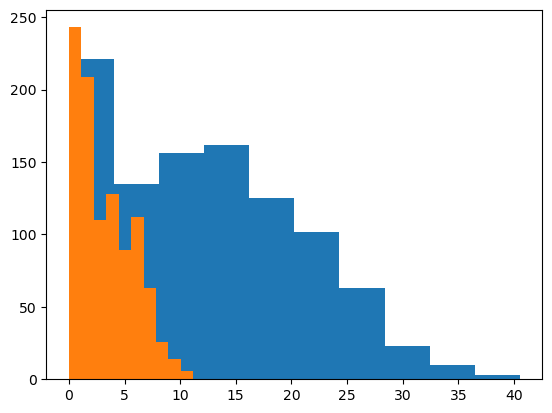

In [135]:
plt.hist(mfp_pMpc_z525,label="z=5.25")
plt.hist(mfp_pMpc_z610,label="z=6.10")

In [136]:
# np.save("tau_profiles_C_a0.1409.npy",tau_profiles)
# np.save("tau_profiles_C_a0.1600.npy",tau_profiles)
# np.savetxt("tau_profile_lambdaAA.txt",tau_profiles)

### quasar los

In [53]:
rootpath="/data/hqchen/mfp_project/data/"
zuni=1/0.1452-1
Hz=cosmo.H(zuni).value
print(zuni)
qsolos=h5py.File(rootpath+"sp17_1.4e+57_F_a01452_xT.hdf5",'r')

5.887052341597796


In [55]:
rootpath="/data/hqchen/mfp_project/data/"
folder="F_a0.1452_50pMpc/"
zuni=1/0.1452-1
Hz=cosmo.H(zuni).value
print(zuni)

5.887052341597796


In [70]:
tau_profiles=[]
for losName in list(qsolos.keys())[:]:
    los=yt.load(rootpath+folder+losName+".h5")
    dr=los.r["dl"].to("Mpc").value
    dist=np.cumsum(los.r["dl"].to("Mpc").value)
    nHI=(los.r['gas','RT_HVAR_HI']/yt.units.mp).in_units("cm**-3").v
    vlos=los.r['gas','velocity_los'].to("km/s").v
    cut_inner=0.15
    tau_profiles.append(integ_tau(vout,dist[dist>cut_inner],nHI[dist>cut_inner],vlos[dist>cut_inner],dr[dist>cut_inner],Hz))

yt : [INFO     ] 2024-01-29 10:20:21,285 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:20:21,286 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:20:21,287 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:20:21,288 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:20:21,289 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:20:21,289 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:20:21,290 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:20:21,291 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:20:21,292 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:20:21,292 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 10:20:25,247 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:20:25,248 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:20:25,249 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:20:25,249 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:20:25,250 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:20:25,251 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:20:25,251 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:20:25,252 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:20:25,258 Allocating for 7.307e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:20:25,264 Identified 4.945e+03 octs
yt : [INFO     ] 2024-01-29 10:20:2

yt : [INFO     ] 2024-01-29 10:20:28,929 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:20:28,929 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:20:28,930 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:20:28,931 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:20:28,931 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:20:28,932 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:20:28,937 Allocating for 7.164e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:20:28,944 Identified 4.529e+03 octs
yt : [INFO     ] 2024-01-29 10:20:29,413 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:20:29,414 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:20:29,415 Parameters: domain

yt : [INFO     ] 2024-01-29 10:20:32,754 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:20:32,755 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:20:32,756 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:20:32,757 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:20:32,768 Allocating for 5.463e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:20:32,779 Identified 3.945e+03 octs
yt : [INFO     ] 2024-01-29 10:20:33,399 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:20:33,400 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:20:33,401 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:20:33,402 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10

yt : [ERROR    ] 2024-01-29 10:20:36,836 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:20:36,836 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:20:36,843 Allocating for 7.833e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:20:36,849 Identified 5.353e+03 octs
yt : [INFO     ] 2024-01-29 10:20:37,377 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:20:37,378 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:20:37,379 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:20:37,380 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:20:37,381 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:20:37,382 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:20:37,383 Para

yt : [INFO     ] 2024-01-29 10:20:40,929 Allocating for 7.696e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:20:40,935 Identified 5.425e+03 octs
yt : [INFO     ] 2024-01-29 10:20:41,460 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:20:41,461 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:20:41,462 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:20:41,463 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:20:41,464 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:20:41,465 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:20:41,466 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:20:41,467 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:20:41,467

yt : [INFO     ] 2024-01-29 10:20:45,567 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:20:45,568 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:20:45,569 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:20:45,570 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:20:45,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:20:45,572 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:20:45,573 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:20:45,573 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:20:45,574 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:20:45,575 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 10:20:49,584 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:20:49,585 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:20:49,586 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:20:49,587 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:20:49,588 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:20:49,589 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:20:49,589 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:20:49,590 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:20:49,596 Allocating for 6.933e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:20:49,602 Identified 4.665e+03 octs
yt : [INFO     ] 2024-01-29 10:20:5

yt : [INFO     ] 2024-01-29 10:20:53,409 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:20:53,410 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:20:53,410 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:20:53,411 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:20:53,412 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:20:53,413 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:20:53,418 Allocating for 6.828e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:20:53,424 Identified 3.841e+03 octs
yt : [INFO     ] 2024-01-29 10:20:53,929 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:20:53,930 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:20:53,931 Parameters: domain

yt : [INFO     ] 2024-01-29 10:20:57,261 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:20:57,261 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:20:57,262 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:20:57,263 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:20:57,268 Allocating for 8.252e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:20:57,275 Identified 5.513e+03 octs
yt : [INFO     ] 2024-01-29 10:20:57,816 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:20:57,817 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:20:57,818 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:20:57,819 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10

yt : [ERROR    ] 2024-01-29 10:21:01,283 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:21:01,284 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:21:01,290 Allocating for 6.032e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:21:01,295 Identified 4.273e+03 octs
yt : [INFO     ] 2024-01-29 10:21:01,760 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:21:01,761 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:21:01,762 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:21:01,763 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:21:01,764 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:21:01,765 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:21:01,766 Para

yt : [INFO     ] 2024-01-29 10:21:05,150 Allocating for 6.824e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:21:05,158 Identified 4.617e+03 octs
yt : [INFO     ] 2024-01-29 10:21:05,639 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:21:05,640 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:21:05,641 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:21:05,642 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:21:05,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:21:05,644 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:21:05,645 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:21:05,645 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:21:05,646

yt : [INFO     ] 2024-01-29 10:21:09,386 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:21:09,388 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:21:09,389 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:21:09,390 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:21:09,391 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:21:09,392 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:21:09,393 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:21:09,393 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:21:09,394 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:21:09,395 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 10:21:13,401 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:21:13,402 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:21:13,403 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:21:13,404 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:21:13,404 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:21:13,405 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:21:13,406 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:21:13,407 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:21:13,412 Allocating for 8.129e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:21:13,418 Identified 5.521e+03 octs
yt : [INFO     ] 2024-01-29 10:21:1

In [64]:
qso_t1e7_tau_profiles=[]

for losName in list(qsolos.keys())[:]:
    loslong=yt.load(rootpath+folder+losName+".h5")
    drlong=loslong.r["dl"].to("Mpc").value
    distlong=np.cumsum(loslong.r["dl"].to("Mpc").value)
    nHIlong=(loslong.r['gas','RT_HVAR_HI']/yt.units.mp).in_units("cm**-3").v
    vloslong=loslong.r['gas','velocity_los'].to("km/s").v
    cut_inner=0.15

    
    losinfo=qsolos[losName+'/los.info'][:]
    dist=losinfo[:,0]
    dr=losinfo[:,1]
    xT=qsolos[losName+'/xT_1e7yr'][:]
    nHI_t1e7=losinfo[:,2]*xT[:,1]
    vlos=losinfo[:,-1]
    
    dist_stitch=np.array(list(dist)+list(distlong[distlong>dist[-1]]))
    dr_stitch=np.array(list(dr)+list(drlong[distlong>dist[-1]]))
    nHI_t1e7_stitch=np.array(list(nHI_t1e7)+list(nHIlong[distlong>dist[-1]]))
    vlos_stitch=np.array(list(vlos)+list(vloslong[distlong>dist[-1]]))
    
    qso_t1e7_tau_profiles.append(integ_tau(vout,dist_stitch,nHI_t1e7_stitch,vlos_stitch,dr_stitch,Hz))

yt : [INFO     ] 2024-01-29 10:08:58,211 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:08:58,212 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:08:58,213 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:08:58,214 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:08:58,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:08:58,215 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:08:58,216 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:08:58,216 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:08:58,217 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:08:58,218 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 10:09:02,214 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:02,215 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:09:02,216 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:02,216 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:02,217 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:02,218 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:02,218 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:02,219 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:09:02,225 Allocating for 7.307e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:02,231 Identified 4.945e+03 octs
yt : [INFO     ] 2024-01-29 10:09:0

yt : [INFO     ] 2024-01-29 10:09:06,165 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:06,166 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:06,167 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:06,167 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:06,168 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:06,169 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:09:06,174 Allocating for 7.164e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:06,180 Identified 4.529e+03 octs
yt : [INFO     ] 2024-01-29 10:09:06,673 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:09:06,674 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:09:06,675 Parameters: domain

yt : [INFO     ] 2024-01-29 10:09:10,080 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:10,081 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:10,081 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:10,082 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:09:10,087 Allocating for 5.463e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:10,093 Identified 3.945e+03 octs
yt : [INFO     ] 2024-01-29 10:09:10,547 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:09:10,548 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:09:10,549 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:10,550 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10

yt : [ERROR    ] 2024-01-29 10:09:13,949 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:13,950 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:09:13,956 Allocating for 7.833e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:13,962 Identified 5.353e+03 octs
yt : [INFO     ] 2024-01-29 10:09:14,597 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:09:14,598 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:09:14,599 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:14,600 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:09:14,601 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:14,601 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:14,602 Para

yt : [INFO     ] 2024-01-29 10:09:17,905 Allocating for 7.696e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:17,911 Identified 5.425e+03 octs
yt : [INFO     ] 2024-01-29 10:09:18,432 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:09:18,433 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:09:18,434 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:18,435 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:09:18,436 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:18,437 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:18,437 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:18,438 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:18,439

yt : [INFO     ] 2024-01-29 10:09:22,316 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:09:22,317 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:09:22,318 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:22,319 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:09:22,320 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:22,320 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:22,321 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:22,322 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:22,322 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:22,323 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 10:09:26,281 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:26,282 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:09:26,283 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:26,283 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:26,284 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:26,284 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:26,285 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:26,286 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:09:26,291 Allocating for 6.933e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:26,297 Identified 4.665e+03 octs
yt : [INFO     ] 2024-01-29 10:09:2

yt : [INFO     ] 2024-01-29 10:09:29,920 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:29,920 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:29,921 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:29,922 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:29,922 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:29,923 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:09:29,929 Allocating for 6.828e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:29,935 Identified 3.841e+03 octs
yt : [INFO     ] 2024-01-29 10:09:30,417 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:09:30,418 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:09:30,419 Parameters: domain

yt : [INFO     ] 2024-01-29 10:09:33,743 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:33,743 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:33,744 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:33,745 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:09:33,750 Allocating for 8.252e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:33,757 Identified 5.513e+03 octs
yt : [INFO     ] 2024-01-29 10:09:34,275 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:09:34,276 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:09:34,277 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:34,277 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10

yt : [ERROR    ] 2024-01-29 10:09:37,601 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:37,601 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:09:37,607 Allocating for 6.032e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:37,613 Identified 4.273e+03 octs
yt : [INFO     ] 2024-01-29 10:09:38,079 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:09:38,080 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:09:38,081 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:38,082 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:09:38,083 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:38,083 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:38,084 Para

yt : [INFO     ] 2024-01-29 10:09:41,298 Allocating for 6.824e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:41,304 Identified 4.617e+03 octs
yt : [INFO     ] 2024-01-29 10:09:41,781 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:09:41,783 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:09:41,784 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:41,785 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:09:41,786 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:41,786 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:41,787 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:41,788 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:41,788

yt : [INFO     ] 2024-01-29 10:09:45,311 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-01-29 10:09:45,312 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-01-29 10:09:45,313 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:45,314 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:09:45,314 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:45,315 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:45,316 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:45,317 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:45,317 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:45,318 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-01-29 10:09:49,185 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-01-29 10:09:49,186 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-01-29 10:09:49,186 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-29 10:09:49,187 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-01-29 10:09:49,188 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-01-29 10:09:49,188 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-01-29 10:09:49,189 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-01-29 10:09:49,190 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-01-29 10:09:49,195 Allocating for 8.129e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-01-29 10:09:49,202 Identified 5.521e+03 octs
yt : [INFO     ] 2024-01-29 10:09:4

In [73]:
AAout

array([911.64852941, 910.72703482, 909.80554023, 908.88404564,
       907.96255105, 907.04105646, 906.11956187, 905.19806728,
       904.27657269, 903.3550781 , 902.43358351, 901.51208892,
       900.59059433, 899.66909974, 898.74760515, 897.82611056,
       896.90461597, 895.98312138, 895.06162679, 894.14013219,
       893.2186376 , 892.29714301, 891.37564842, 890.45415383,
       889.53265924, 888.61116465, 887.68967006, 886.76817547,
       885.84668088, 884.92518629, 884.0036917 , 883.08219711,
       882.16070252, 881.23920793, 880.31771334, 879.39621875,
       878.47472416, 877.55322957, 876.63173498, 875.71024039,
       874.7887458 , 873.86725121, 872.94575662, 872.02426203,
       871.10276744, 870.18127284, 869.25977825, 868.33828366,
       867.41678907, 866.49529448, 865.57379989, 864.6523053 ,
       863.73081071, 862.80931612, 861.88782153, 860.96632694,
       860.04483235, 859.12333776, 858.20184317, 857.28034858,
       856.35885399, 855.4373594 , 854.51586481, 853.59

In [76]:
np.savetxt("AAout.txt",AAout,fmt="%7.2f")

In [71]:
np.savetxt("qso_t1e7_tau_profiles.txt",qso_t1e7_tau_profiles,fmt="%6.4e")

In [72]:
np.savetxt("tau_profiles.txt",tau_profiles,fmt="%6.4e")

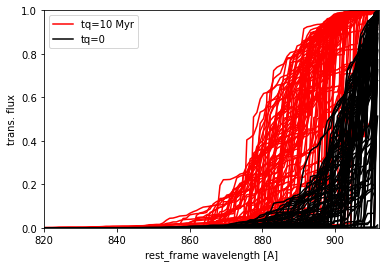

In [68]:
AA_tau1_list_qso_t0=[]
AA_tau1_list_qso_t1e7=[]


    
for tp in qso_t1e7_tau_profiles:
    plt.plot(AAout,np.exp(-tp),c='r')
    plt.ylim(0,1)
    plt.grid()
    
for tp in tau_profiles:
    plt.plot(AAout,np.exp(-tp),c='k')
    plt.ylim(0,1)
    plt.grid()
plt.plot(0,0,c='r',label="tq=10 Myr")
plt.plot(0,0,c='k',label="tq=0")
plt.xlabel("rest_frame wavelength [A]")
plt.ylabel("trans. flux")
plt.xlim(820,912)
plt.legend()

In [75]:
AAout

array([911.64852941, 910.72703482, 909.80554023, 908.88404564,
       907.96255105, 907.04105646, 906.11956187, 905.19806728,
       904.27657269, 903.3550781 , 902.43358351, 901.51208892,
       900.59059433, 899.66909974, 898.74760515, 897.82611056,
       896.90461597, 895.98312138, 895.06162679, 894.14013219,
       893.2186376 , 892.29714301, 891.37564842, 890.45415383,
       889.53265924, 888.61116465, 887.68967006, 886.76817547,
       885.84668088, 884.92518629, 884.0036917 , 883.08219711,
       882.16070252, 881.23920793, 880.31771334, 879.39621875,
       878.47472416, 877.55322957, 876.63173498, 875.71024039,
       874.7887458 , 873.86725121, 872.94575662, 872.02426203,
       871.10276744, 870.18127284, 869.25977825, 868.33828366,
       867.41678907, 866.49529448, 865.57379989, 864.6523053 ,
       863.73081071, 862.80931612, 861.88782153, 860.96632694,
       860.04483235, 859.12333776, 858.20184317, 857.28034858,
       856.35885399, 855.4373594 , 854.51586481, 853.59